In [4]:
''' Demo SDK for LiveStreaming
    Author Dan Yang
    Time 2018-10-15
    For LiveStreaming Game'''
# import the env from pip
import LiveStreamingEnv.env as env
import LiveStreamingEnv.load_trace as load_trace
import matplotlib.pyplot as plt
import time
import numpy as np
# path setting
TRAIN_TRACES = './train_sim_traces/'   #train trace path setting,
video_size_file = './video_size_'      #video trace path setting,
LogFile_Path = "./log/"                #log file trace path setting,
# Debug Mode: if True, You can see the debug info in the logfile
#             if False, no log ,but the training speed is high
DEBUG = True
DRAW = True
# load the trace
all_cooked_time, all_cooked_bw, all_cooked_rtt,_ = load_trace.load_trace(TRAIN_TRACES)
#random_seed 
random_seed = 2
#init the environment
#setting one:
#     1,all_cooked_time : timestamp
#     2,all_cooked_bw   : throughput
#     3,all_cooked_rtt  : rtt
#     4,agent_id        : random_seed
#     5,logfile_path    : logfile_path
#     6,VIDEO_SIZE_FILE : Video Size File Path
#     7,Debug Setting   : Debug
net_env = env.Environment(all_cooked_time=all_cooked_time,
                              all_cooked_bw=all_cooked_bw,
                              all_cooked_rtt=all_cooked_rtt,
                              random_seed=random_seed,
                              logfile_path=LogFile_Path,
                              VIDEO_SIZE_FILE=video_size_file,
                              Debug = DEBUG)

In [6]:
cnt = 0
S_time_interval = []
S_send_data_size = []
S_chunk_len = []
S_rebuf = []
S_buffer_size = []
S_end_delay = []
S_chunk_size = []
S_rtt = []
S_play_time = []
BIT_RATE      = [500,800] # kpbs
TARGET_BUFFER = [2,3]   # seconds
RESEVOIR = 0.5
CUSHION  = 2
last_bit_rate = 0
reward_all = 0
bit_rate = 0
target_buffer = 0
# plot info
idx = 0
id_list = []
bit_rate_record = []
buffer_record = []
throughput_record = []

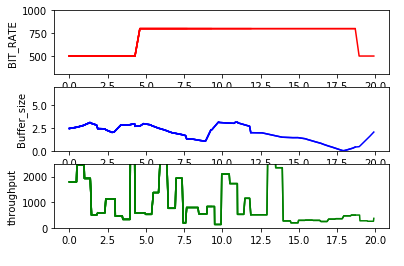

12721.6653736


In [7]:
# plot the real time image
if DRAW:
    fig = plt.figure()
    plt.ion()
    plt.xlabel("time")
    plt.axis('off')

while True:
    # input the train steps
    if cnt > 500:
        plt.ioff()
        break
    #actions bit_rate  target_buffer
    # every steps to call the environment
    # time           : physical time 
    # time_interval  : time duration in this step
    # send_data_size : download frame data size in this step
    # chunk_len      : frame time len
    # rebuf          : rebuf time in this step          
    # buffer_size    : current client buffer_size in this step          
    # rtt            : current buffer  in this step          
    # play_time_len  : played time len  in this step          
    # end_delay      : end to end latency which means the (upload end timestamp - play end timestamp)
    # decision_flag  : Only in decision_flag is True ,you can choose the new actions, other time can't Becasuse the Gop is consist by the I frame and P frame. Only in I frame you can skip your frame
    # buffer_flag    : If the True which means the video is rebuffing , client buffer is rebuffing, no play the video
    # cdn_flag       : If the True cdn has no frame to get 
    # end_of_video   : If the True ,which means the video is over.
    time, time_interval, send_data_size, chunk_len, rebuf, buffer_size, rtt, play_time_len,end_delay, decision_flag, buffer_flag,cdn_flag, end_of_video = net_env.get_video_frame(bit_rate,TARGET_BUFFER[target_buffer])
    cnt += 1
    if time_interval != 0:
        # plot bit_rate 
        id_list.append(idx)
        idx += time_interval
        bit_rate_record.append(BIT_RATE[bit_rate])
        # plot buffer 
        buffer_record.append(buffer_size)
        # plot throughput 
        trace_idx = net_env.get_trace_id()
        throughput_record.append(all_cooked_bw[trace_idx][int(idx/0.5)] * 1000 )

    if decision_flag :
        # reward formate = play_time * BIT_RATE - 4.3 * rebuf - 1.2 * end_delay
        reward =  sum(S_play_time) *  BIT_RATE[bit_rate] - 0.8 *  sum(S_rebuf) -  0.2 * (end_delay - 3)  - abs(BIT_RATE[bit_rate] - BIT_RATE[last_bit_rate])   
        reward_all += reward

        # last_bit_rate
        last_bit_rate = bit_rate

        
        # draw setting
        if DRAW:
            ax = fig.add_subplot(311)
            plt.ylabel("BIT_RATE")
            plt.ylim(300,1000)
            plt.plot(id_list,bit_rate_record,'-r')
        
            ax = fig.add_subplot(312)
            plt.ylabel("Buffer_size")
            plt.ylim(0,7)
            plt.plot(id_list,buffer_record,'-b')

            ax = fig.add_subplot(313)
            plt.ylabel("throughput")
            plt.ylim(0,2500)
            plt.plot(id_list,throughput_record,'-g')

            plt.draw()
            plt.pause(0.01)



        # -------------------------------------------Your Althgrithom ------------------------------------------- 
        # which part is the althgrothm part ,the buffer based , 
        # if the buffer is enough ,choose the high quality
        # if the buffer is danger, choose the low  quality
        # if there is no rebuf ,choose the low target_buffer

        if buffer_size < RESEVOIR:
            bit_rate = 0
        elif buffer_size >= RESEVOIR + CUSHION:
            bit_rate = 1
        rebuf_list = [i for i in S_rebuf if i > 0] 

        if sum(rebuf_list) > sum(S_chunk_len):
            target_buffer = 0
        else:
            target_buffer = 1

        # ------------------------------------------- End  ------------------------------------------- 


        S_time_interval = []
        S_send_data_size = []
        S_chunk_len = []
        S_rebuf = []
        S_buffer_size = [] 
        S_end_delay = []
        S_rtt = []
        S_play_time = []
        S_chunk_size = []


    S_time_interval.append(time_interval)
    S_send_data_size.append(send_data_size)
    S_chunk_len.append(chunk_len)
    S_buffer_size.append(buffer_size)
    S_rebuf.append(rebuf)
    S_end_delay.append(end_delay)
    S_rtt.append(rtt)
    S_play_time.append(play_time_len)
        
    # output
if DRAW:
    plt.show()
print(reward_all)
